In [1]:
# Importing libraries to be used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from prophet import Prophet

In [2]:
# reading the dataset
data = pd.read_csv('test.csv')
# displaying the data set to get its initial view
data.head()

,NAV,Units,Sale Price/Unit,Repurchase Price/Unit,Date Valued,Scheme Name_Bond Fund,Scheme Name_Jikimu Fund,Scheme Name_Liquid Fund,Scheme Name_Umoja Fund,Scheme Name_Watoto Fund,Scheme Name_Wekeza Maisha Fund
0,3.022917e+11,3.446718e+08,877.0422,868.2718,2022-12-30,0,0,0,1,0,0
1,6.658728e+09,8.978248e+06,741.6512,726.8182,2022-12-30,0,0,0,0,0,1
2,8.426930e+09,1.537832e+07,547.9748,542.4951,2022-12-30,0,0,0,0,1,0
3,1.912265e+10,1.201808e+08,159.1157,155.9333,2022-12-30,0,1,0,0,0,0
4,5.592721e+11,1.632829e+09,342.5173,342.5173,2022-12-30,0,0,1,0,0,0


In [3]:
# Creating a copy of the data as df for easy naming & for future use as reference
df_copy = data.copy()

# Create a new DataFrame where 'Value' column is equal to 1
datat = data[data['Scheme Name_Jikimu Fund'] == 1]


# List of columns to drop
columns_to_drop = ['Scheme Name_Liquid Fund', 'Scheme Name_Bond Fund','Scheme Name_Umoja Fund','Scheme Name_Watoto Fund',
'Scheme Name_Wekeza Maisha Fund']

# Drop the specified columns
datat.drop(columns=columns_to_drop, inplace=True)

# Checking our data now to see if it has the columns we want
datat.head()


C:\Users\johnb\AppData\Local\Temp\ipykernel_16500\2012705150.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datat.drop(columns=columns_to_drop, inplace=True)


,NAV,Units,Sale Price/Unit,Repurchase Price/Unit,Date Valued,Scheme Name_Jikimu Fund
3,1.912265e+10,1.201808e+08,159.1157,155.9333,2022-12-30,1
9,1.909805e+10,1.201027e+08,159.0143,155.8340,2022-12-29,1
15,1.911025e+10,1.202059e+08,158.9794,155.7998,2022-12-28,1
21,1.910533e+10,1.202008e+08,158.9450,155.7661,2022-12-27,1
27,1.908263e+10,1.201617e+08,158.8080,155.6318,2022-12-23,1


In [4]:
# Renaming the column to a suitable format that prophet can use
datat.rename(columns={'Date Valued': 'ds'}, inplace=True)
datat.rename(columns={'Sale Price/Unit': 'y'}, inplace=True)

C:\Users\johnb\AppData\Local\Temp\ipykernel_16500\3204513736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datat.rename(columns={'Date Valued': 'ds'}, inplace=True)
C:\Users\johnb\AppData\Local\Temp\ipykernel_16500\3204513736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datat.rename(columns={'Sale Price/Unit': 'y'}, inplace=True)


In [6]:
# Droping all the columns that we won't use for trainig. 
df=datat.drop(['NAV','Units','Repurchase Price/Unit','Scheme Name_Jikimu Fund'],axis=1)

# Coverting ds column to datetime data type
df['ds'] = pd.to_datetime(df['ds'])

# Droping duplicates for the columns
df=df.drop_duplicates()

# Sort by descending order of dates
df = df.sort_values(by='ds', ascending=False)

In [9]:
# Puting option to show all rows
#pd.set_option('display.max_rows',None)
#pd.reset_option('display.max_rows',)


In [7]:
#Create a new column 'New_Column' with values 0 by default
df['regressor_1'] = 0

# Set values to 0.5 for specific dates
df.loc[df['ds'].isin(['2018-03-13', '2018-12-20']), 'regressor_1'] = 0.5

# Set values to 1 for specific dates
df.loc[df['ds'].isin(['2019-05-20', '2019-10-14']), 'regressor_1'] = 1

# Set values to 2 for specific dates
df.loc[df['ds'].isin(['2022-04-10']), 'regressor_1'] = 2


In [8]:
# Showing the dataset now
df

,y,ds,regressor_1
3,159.1157,2022-12-30,0.0
9,159.0143,2022-12-29,0.0
15,158.9794,2022-12-28,0.0
21,158.9450,2022-12-27,0.0
27,158.8080,2022-12-23,0.0
...,...,...,...
7332,125.3008,2017-01-11,0.0
7952,124.2844,2017-01-08,0.0
8347,124.1509,2017-01-06,0.0
8880,123.4265,2017-01-03,0.0


In [9]:
# Create a Prophet forecasting model with the following settings:
prophet=Prophet(growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',            
    holidays=None,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)

# - Additional external regressor component called regressor_1
prophet.add_regressor('regressor_1')



In [10]:
# Fit the Prophet model to historical data
prophet.fit(df)

15:48:35 - cmdstanpy - INFO - Chain [1] start processing
15:48:35 - cmdstanpy - INFO - Chain [1] done processing


In [11]:

# Create a new DataFrame to hold future dates for forecasting
# The 'periods' parameter specifies how far into the future you want to forecast (180 periods in this case)
future = prophet.make_future_dataframe(periods=180) 

In [12]:
# add the regressor column
future['regressor_1'] = 0


In [13]:
future

,ds,regressor_1
0,2017-01-02,0
1,2017-01-03,0
2,2017-01-06,0
3,2017-01-08,0
4,2017-01-11,0
...,...,...
1650,2023-06-24,0
1651,2023-06-25,0
1652,2023-06-26,0
1653,2023-06-27,0


In [14]:
# Use the fitted Prophet model to make predictions for the future dates
forecast = prophet.predict(future)

In [15]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-01-02,123.208683,115.098402,132.367706,123.208683,123.208683,-0.005528,-0.005528,-0.005528,0.005804,...,-0.001674,-0.001674,-0.001674,0.013007,0.013007,0.013007,0.0,0.0,0.0,123.923835
1,2017-01-03,123.218002,115.182323,132.785915,123.218002,123.218002,-0.005528,-0.005528,-0.005528,0.006027,...,-0.001625,-0.001625,-0.001625,0.013181,0.013181,0.013181,0.0,0.0,0.0,123.960638
2,2017-01-06,123.245962,116.254234,132.815435,123.245962,123.245962,-0.005528,-0.005528,-0.005528,0.008109,...,0.001204,0.001204,0.001204,0.012434,0.012434,0.012434,0.0,0.0,0.0,124.245349
3,2017-01-08,123.264601,116.023198,134.105012,123.264601,123.264601,-0.005528,-0.005528,-0.005528,0.010712,...,0.005265,0.005265,0.005265,0.010976,0.010976,0.010976,0.0,0.0,0.0,124.585030
4,2017-01-11,123.292561,114.238288,132.440676,123.292561,123.292561,-0.005528,-0.005528,-0.005528,0.002455,...,0.000272,0.000272,0.000272,0.007712,0.007712,0.007712,0.0,0.0,0.0,123.595301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650,2023-06-24,164.035308,156.063246,173.305990,163.398550,164.792057,-0.005528,-0.005528,-0.005528,0.001948,...,-0.002678,-0.002678,-0.002678,0.010154,0.010154,0.010154,0.0,0.0,0.0,164.354809
1651,2023-06-25,164.057115,157.366623,174.553729,163.412438,164.819701,-0.005528,-0.005528,-0.005528,0.010020,...,0.005265,0.005265,0.005265,0.010284,0.010284,0.010284,0.0,0.0,0.0,165.700995
1652,2023-06-26,164.078921,155.628149,173.360998,163.426327,164.847346,-0.005528,-0.005528,-0.005528,0.003139,...,-0.001674,-0.001674,-0.001674,0.010342,0.010342,0.010342,0.0,0.0,0.0,164.593995
1653,2023-06-27,164.100728,155.501173,173.270371,163.440679,164.878950,-0.005528,-0.005528,-0.005528,0.003166,...,-0.001625,-0.001625,-0.001625,0.010320,0.010320,0.010320,0.0,0.0,0.0,164.620297


In [16]:
# Convert start_date and end_date to the same datetime format
start_date = pd.to_datetime('2023-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2023-07-01', format='%Y-%m-%d')

# Use df.loc to filter based on date range
filtered_df = forecast.loc[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]


In [17]:
# Sort the DataFrame 'filtered_df' by the 'ds' column in ascending order
filtered_df = filtered_df.sort_values(by='ds', ascending=True)

In [18]:
filtered_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1476,2023-01-01,160.240971,153.969578,170.651563,160.240971,160.240971,-0.005528,-0.005528,-0.005528,0.012079,...,0.005265,0.005265,0.005265,0.012343,0.012343,0.012343,0.0,0.0,0.0,162.176554
1477,2023-01-02,160.262777,152.486737,169.742236,160.262777,160.262777,-0.005528,-0.005528,-0.005528,0.005636,...,-0.001674,-0.001674,-0.001674,0.012839,0.012839,0.012839,0.0,0.0,0.0,161.166097
1478,2023-01-03,160.284584,152.634172,169.730931,160.284584,160.284584,-0.005528,-0.005528,-0.005528,0.005967,...,-0.001625,-0.001625,-0.001625,0.013121,0.013121,0.013121,0.0,0.0,0.0,161.241017
1479,2023-01-04,160.306390,153.028266,170.363366,160.306390,160.306390,-0.005528,-0.005528,-0.005528,0.007930,...,0.000272,0.000272,0.000272,0.013187,0.013187,0.013187,0.0,0.0,0.0,161.577663
1480,2023-01-05,160.328197,152.847137,169.871836,160.328197,160.328197,-0.005528,-0.005528,-0.005528,0.006749,...,-0.000762,-0.000762,-0.000762,0.013039,0.013039,0.013039,0.0,0.0,0.0,161.410216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650,2023-06-24,164.035308,156.063246,173.305990,163.398550,164.792057,-0.005528,-0.005528,-0.005528,0.001948,...,-0.002678,-0.002678,-0.002678,0.010154,0.010154,0.010154,0.0,0.0,0.0,164.354809
1651,2023-06-25,164.057115,157.366623,174.553729,163.412438,164.819701,-0.005528,-0.005528,-0.005528,0.010020,...,0.005265,0.005265,0.005265,0.010284,0.010284,0.010284,0.0,0.0,0.0,165.700995
1652,2023-06-26,164.078921,155.628149,173.360998,163.426327,164.847346,-0.005528,-0.005528,-0.005528,0.003139,...,-0.001674,-0.001674,-0.001674,0.010342,0.010342,0.010342,0.0,0.0,0.0,164.593995
1653,2023-06-27,164.100728,155.501173,173.270371,163.440679,164.878950,-0.005528,-0.005528,-0.005528,0.003166,...,-0.001625,-0.001625,-0.001625,0.010320,0.010320,0.010320,0.0,0.0,0.0,164.620297


In [20]:
# Read data from a CSV file 'Bond Fund_test_1.csv' into a DataFrame 'vz_plot'
vz_plot=pd.read_csv('Test data/Jikimu Fund_test_1.csv')


In [21]:
# Convert the 'date_valued' column in the 'vz_plot' DataFrame to datetime format
vz_plot['date_valued'] = pd.to_datetime(vz_plot['date_valued'])


In [22]:
# Convert the 'date_valued' column in the 'vz_plot' DataFrame to datetime format
desired_date_format = '%d-%m-%Y'
vz_plot['date_valued'] = vz_plot['date_valued'].dt.strftime(desired_date_format)

In [23]:
# Convert the 'date_valued' column in the 'vz_plot' DataFrame to datetime format
vz_plot['date_valued'] = pd.to_datetime(vz_plot['date_valued'],format='%d-%m-%Y')


In [24]:
vz_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name_scheme                124 non-null    object        
 1   net_asset_value            124 non-null    object        
 2   outstanding_no_of_units    124 non-null    object        
 3   nav_per_unit               124 non-null    float64       
 4   sale_price_per_unit        124 non-null    float64       
 5   repurchase_price_per_unit  124 non-null    float64       
 6   date_valued                124 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 6.9+ KB


In [25]:
# Sort by acsending date values
vz_plot = vz_plot.sort_values(by='date_valued', ascending=True)

In [26]:
# Merge two DataFrames, 'filtered_df' and 'vz_plot', using an inner join on the 'ds' and 'date_valued' columns
# The resulting DataFrame 'merged_df' will contain columns 'ds' and 'yhat' from 'filtered_df' and 'date_valued' 
#and 'nav_per_unit' from 'vz_plot'
merged_df = pd.merge(filtered_df[['ds', 'yhat']], vz_plot[['date_valued', 'nav_per_unit']], left_on='ds', right_on='date_valued', how='inner')

# Drop the duplicate 'date_valued' column
merged_df = merged_df.drop(columns='date_valued')

# Rename columns if needed
merged_df = merged_df.rename(columns={'yhat': 'yhat_values', 'nav_per_unit': 'nav_values'})

# Display the merged dataframe
merged_df

,ds,yhat_values,nav_values
0,2023-01-02,161.166097,156.2657
1,2023-01-03,161.241017,156.2861
2,2023-01-04,161.577663,156.4217
3,2023-01-05,161.410216,156.4896
4,2023-01-06,161.690575,156.5241
...,...,...,...
118,2023-06-22,164.552882,166.2317
119,2023-06-23,164.937896,166.2660
120,2023-06-26,164.593995,166.3690
121,2023-06-27,164.620297,166.3223


<Axes: title={'center': 'Comparison plot'}, xlabel='ds'>

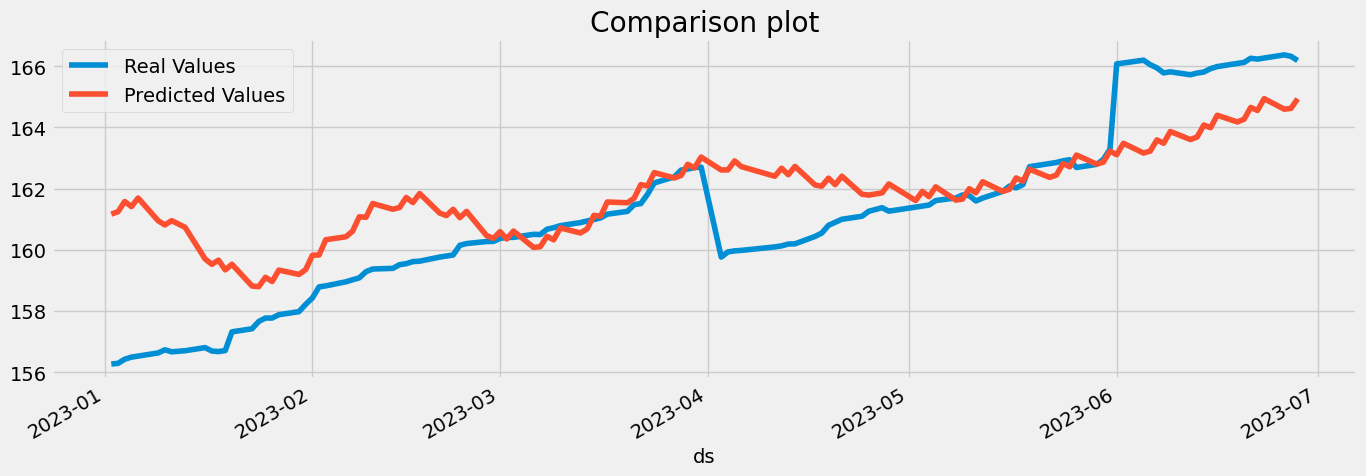

In [27]:
# Create a Matplotlib figure and axis with a specific figsize
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the 'nav_values' column from 'merged_df' as 'Real Values' on the same axis ('ax')
# Set the title of the plot as 'Comparison plot'
merged_df.plot(ax=ax, x='ds',y='nav_values', label='Real Values', title='Comparison plot')
merged_df.plot(ax=ax, x='ds',y='yhat_values', label='Predicted Values',)

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Assuming you have a test set with actual values
y_test = merged_df['nav_values']
# Replace with your actual test data

# Extract the forecasted values from the Prophet forecast object
y_pred = merged_df['yhat_values']

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Optionally, calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print("R-squared (R2) Score:", r2)

Mean Absolute Error (MAE): 1.4304431323607145
Mean Squared Error (MSE): 3.6875543474696397
Root Mean Squared Error (RMSE): 1.9203005877907864
R-squared (R2) Score: 0.5303992697846056


In [29]:
# Rename the 'yhat_values' column to 'Predicted_nav_values' and 'nav_values' column to 'Real_nav_values'
merged_df.rename(columns={'yhat_values': 'Predicted_nav_values', 'nav_values': 'Real_nav_values'}, inplace=True)
# Store the next 6 months predictions
merged_df.to_csv('Next 6 months prediction for Jikimu Fund.csv', index=False)

In [35]:
import pickle as pkl

In [37]:
# saving the model as a pkl file
pkl.dump(prophet,open('Jikimu fund1 predictor.pkl','wb'))
# loaded_file=pickel.load(open('Umoja fund predictor.pkl','rb'))
# loaded_file.predict(X_test)

In [113]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days,61.722600,7.856373,2.079432,0.012387,0.009680,0.012548,0.994681
1,19 days,61.035623,7.812530,1.999369,0.011873,0.009414,0.012012,0.994681
2,20 days,60.746352,7.793995,1.969142,0.011701,0.009221,0.011827,0.995285
3,21 days,60.893825,7.803450,1.996310,0.011962,0.009221,0.012063,0.997340
4,22 days,61.192419,7.822558,2.043194,0.012361,0.009267,0.012442,0.997340
...,...,...,...,...,...,...,...,...
158,176 days,10.765733,3.281118,2.888794,0.019776,0.017769,0.019778,0.997340
159,177 days,12.121955,3.481660,3.025428,0.020732,0.018369,0.020715,0.994681
160,178 days,13.590446,3.686522,3.147319,0.021567,0.018668,0.021544,0.984043
161,179 days,14.953108,3.866925,3.265069,0.022349,0.018792,0.022345,0.978723


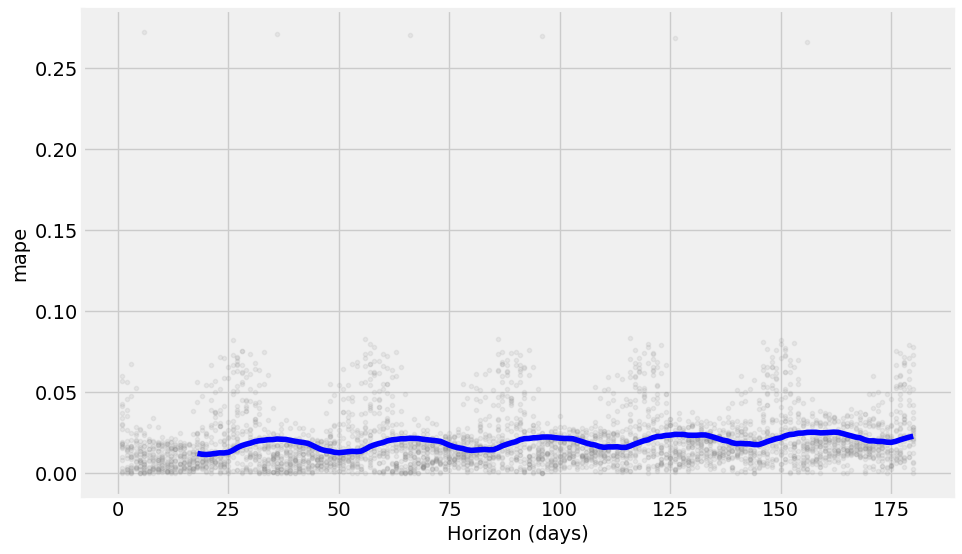

In [114]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Model optimization

In [124]:
# Define a custom estimator class 'ProphetEstimator' that inherits from 'BaseEstimator'
# This class is designed for use with scikit-learn and allows for custom configuration of a Prophet mode
class ProphetEstimator(BaseEstimator):
    def __init__(self, yearly_seasonality, weekly_seasonality, daily_seasonality,
                 seasonality_mode, seasonality_prior_scale, holidays_prior_scale,
                 changepoint_prior_scale):
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality
        self.seasonality_mode = seasonality_mode
        self.seasonality_prior_scale = seasonality_prior_scale
        self.holidays_prior_scale = holidays_prior_scale
        self.changepoint_prior_scale = changepoint_prior_scale
        # Initialize the estimator with configurable Prophet model hyperparameters
    def fit(self, X, y=None):
        self.model = Prophet(
            yearly_seasonality=self.yearly_seasonality,
            weekly_seasonality=self.weekly_seasonality,
            daily_seasonality=self.daily_seasonality,
            seasonality_mode=self.seasonality_mode,
            seasonality_prior_scale=self.seasonality_prior_scale,
            holidays_prior_scale=self.holidays_prior_scale,
            changepoint_prior_scale=self.changepoint_prior_scale
        )
        self.model.fit(X)

    def predict(self, X):
        # Generate predictions using the fitted Prophet model
        forecast = self.model.predict(X)
        return forecast


In [125]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'yearly_seasonality': ['auto', False],
    'weekly_seasonality': ['auto', False],
    'daily_seasonality': ['auto', False],
    'seasonality_mode': ['multiplicative', 'additive'],
    'seasonality_prior_scale': [1, 5, 10, 20],
    'holidays_prior_scale': [5, 10, 20, 25],
    'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]
}

prophet_estimator = ProphetEstimator(
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    seasonality_mode='multiplicative',
    seasonality_prior_scale=1,
    holidays_prior_scale=5,
    changepoint_prior_scale=0.005
)

grid_search = GridSearchCV(estimator=prophet_estimator, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to your data (assuming 'X_train' is your training data)
grid_search.fit(df)

# Get the best combination of hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)
print(best_model)

15:35:38 - cmdstanpy - INFO - Chain [1] start processing
15:35:38 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:35:39 - cmdstanpy - INFO - Chain [1] start processing
15:35:39 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:35:46 - cmdstanpy - INFO - Chain [1] start processing
15:35:46 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:35:47 - cmdstanpy - INFO - Chain [1] start processing
15:35:47 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:35:53 - cmdstanpy - INFO - Chain [1] start processing
15:35:54 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:35:54 - cmdstanpy - INFO - Chain [1] start processing
15:35:54 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:36:01 - cmdstanpy - INFO - Chain [1] start processing
15:36:01 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:36:02 - cmdstanpy - INFO - Chain [1] start processing
15:36:02 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:36:09 - cmdstanpy - INFO - Chain [1] start processing
15:36:09 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:36:10 - cmdstanpy - INFO - Chain [1] start processing
15:36:10 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:36:17 - cmdstanpy - INFO - Chain [1] start processing
15:36:18 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:36:18 - cmdstanpy - INFO - Chain [1] start processing
15:36:18 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:36:26 - cmdstanpy - INFO - Chain [1] start processing
15:36:26 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:36:26 - cmdstanpy - INFO - Chain [1] start processing
15:36:26 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:36:34 - cmdstanpy - INFO - Chain [1] start processing
15:36:34 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:36:34 - cmdstanpy - INFO - Chain [1] start processing
15:36:34 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:36:42 - cmdstanpy - INFO - Chain [1] start processing
15:36:42 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:36:42 - cmdstanpy - INFO - Chain [1] start processing
15:36:43 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:36:49 - cmdstanpy - INFO - Chain [1] start processing
15:36:49 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:36:50 - cmdstanpy - INFO - Chain [1] start processing
15:36:50 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:36:56 - cmdstanpy - INFO - Chain [1] start processing
15:36:56 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:36:57 - cmdstanpy - INFO - Chain [1] start processing
15:36:57 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:37:04 - cmdstanpy - INFO - Chain [1] start processing
15:37:04 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:37:04 - cmdstanpy - INFO - Chain [1] start processing
15:37:04 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:37:11 - cmdstanpy - INFO - Chain [1] start processing
15:37:11 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:37:11 - cmdstanpy - INFO - Chain [1] start processing
15:37:12 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:37:18 - cmdstanpy - INFO - Chain [1] start processing
15:37:18 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:37:19 - cmdstanpy - INFO - Chain [1] start processing
15:37:19 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:37:26 - cmdstanpy - INFO - Chain [1] start processing
15:37:26 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:37:26 - cmdstanpy - INFO - Chain [1] start processing
15:37:26 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:37:33 - cmdstanpy - INFO - Chain [1] start processing
15:37:33 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:37:33 - cmdstanpy - INFO - Chain [1] start processing
15:37:33 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:37:41 - cmdstanpy - INFO - Chain [1] start processing
15:37:42 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:37:42 - cmdstanpy - INFO - Chain [1] start processing
15:37:42 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:37:48 - cmdstanpy - INFO - Chain [1] start processing
15:37:48 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:37:48 - cmdstanpy - INFO - Chain [1] start processing
15:37:49 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:37:56 - cmdstanpy - INFO - Chain [1] start processing
15:37:56 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:37:57 - cmdstanpy - INFO - Chain [1] start processing
15:37:57 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:38:04 - cmdstanpy - INFO - Chain [1] start processing
15:38:04 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:38:04 - cmdstanpy - INFO - Chain [1] start processing
15:38:04 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:38:10 - cmdstanpy - INFO - Chain [1] start processing
15:38:11 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:38:11 - cmdstanpy - INFO - Chain [1] start processing
15:38:11 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:38:19 - cmdstanpy - INFO - Chain [1] start processing
15:38:19 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:38:19 - cmdstanpy - INFO - Chain [1] start processing
15:38:19 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:38:26 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:38:26 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:38:33 - cmdstanpy - INFO - Chain [1] start processing
15:38:33 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:38:34 - cmdstanpy - INFO - Chain [1] start processing
15:38:34 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:38:41 - cmdstanpy - INFO - Chain [1] start processing
15:38:41 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:38:41 - cmdstanpy - INFO - Chain [1] start processing
15:38:41 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:38:48 - cmdstanpy - INFO - Chain [1] start processing
15:38:48 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:38:49 - cmdstanpy - INFO - Chain [1] start processing
15:38:49 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:38:56 - cmdstanpy - INFO - Chain [1] start processing
15:38:56 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:38:57 - cmdstanpy - INFO - Chain [1] start processing
15:38:57 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:39:04 - cmdstanpy - INFO - Chain [1] start processing
15:39:04 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:39:04 - cmdstanpy - INFO - Chain [1] start processing
15:39:04 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:39:13 - cmdstanpy - INFO - Chain [1] start processing
15:39:13 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:39:14 - cmdstanpy - INFO - Chain [1] start processing
15:39:14 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:39:21 - cmdstanpy - INFO - Chain [1] start processing
15:39:21 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:39:22 - cmdstanpy - INFO - Chain [1] start processing
15:39:22 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:39:28 - cmdstanpy - INFO - Chain [1] start processing
15:39:29 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:39:29 - cmdstanpy - INFO - Chain [1] start processing
15:39:29 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:39:37 - cmdstanpy - INFO - Chain [1] start processing
15:39:37 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:39:37 - cmdstanpy - INFO - Chain [1] start processing
15:39:38 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:39:44 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:39:45 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:39:52 - cmdstanpy - INFO - Chain [1] start processing
15:39:52 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:39:53 - cmdstanpy - INFO - Chain [1] start processing
15:39:53 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:40:00 - cmdstanpy - INFO - Chain [1] start processing
15:40:00 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:40:00 - cmdstanpy - INFO - Chain [1] start processing
15:40:00 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:40:07 - cmdstanpy - INFO - Chain [1] start processing
15:40:07 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:40:08 - cmdstanpy - INFO - Chain [1] start processing
15:40:08 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:40:15 - cmdstanpy - INFO - Chain [1] start processing
15:40:15 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:40:16 - cmdstanpy - INFO - Chain [1] start processing
15:40:16 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:40:22 - cmdstanpy - INFO - Chain [1] start processing
15:40:22 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:40:23 - cmdstanpy - INFO - Chain [1] start processing
15:40:23 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:40:31 - cmdstanpy - INFO - Chain [1] start processing
15:40:31 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:40:31 - cmdstanpy - INFO - Chain [1] start processing
15:40:32 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:40:38 - cmdstanpy - INFO - Chain [1] start processing
15:40:38 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:40:39 - cmdstanpy - INFO - Chain [1] start processing
15:40:39 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:40:46 - cmdstanpy - INFO - Chain [1] start processing
15:40:46 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:40:47 - cmdstanpy - INFO - Chain [1] start processing
15:40:47 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:40:54 - cmdstanpy - INFO - Chain [1] start processing
15:40:54 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:40:55 - cmdstanpy - INFO - Chain [1] start processing
15:40:55 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:41:02 - cmdstanpy - INFO - Chain [1] start processing
15:41:02 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:41:02 - cmdstanpy - INFO - Chain [1] start processing
15:41:02 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:41:09 - cmdstanpy - INFO - Chain [1] start processing
15:41:10 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:41:10 - cmdstanpy - INFO - Chain [1] start processing
15:41:10 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:41:18 - cmdstanpy - INFO - Chain [1] start processing
15:41:18 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:41:18 - cmdstanpy - INFO - Chain [1] start processing
15:41:18 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

{'changepoint_prior_scale': 0.05, 'daily_seasonality': 'auto', 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}
ProphetEstimator(changepoint_prior_scale=0.05, daily_seasonality='auto',
                 holidays_prior_scale=10.0, seasonality_mode='multiplicative',
                 seasonality_prior_scale=10.0, weekly_seasonality='auto',
                 yearly_seasonality='auto')


In [126]:
class ProphetEstimator(BaseEstimator):
    def __init__(self, seasonality_mode, seasonality_prior_scale, holidays_prior_scale, changepoint_prior_scale):
        self.seasonality_mode = seasonality_mode
        self.seasonality_prior_scale = seasonality_prior_scale
        self.holidays_prior_scale = holidays_prior_scale
        self.changepoint_prior_scale = changepoint_prior_scale

    def fit(self, X, y=None):
        self.model = Prophet(
            seasonality_mode=self.seasonality_mode,
            seasonality_prior_scale=self.seasonality_prior_scale,
            holidays_prior_scale=self.holidays_prior_scale,
            changepoint_prior_scale=self.changepoint_prior_scale
        )
        self.model.fit(X)

    def predict(self, X):
        forecast = self.model.predict(X)
        return forecast

# Specify the hyperparameter grid
param_grid = {
    'seasonality_mode': ["additive", 'multiplicative'],
    'seasonality_prior_scale': [1, 5, 10, 20],
    'holidays_prior_scale': [5, 10, 20, 25],
    'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]
}

# Create an instance of ProphetEstimator
prophet_estimator = ProphetEstimator(
    seasonality_mode='additive',  # You can start with a default value
    seasonality_prior_scale=1,    # You can start with a default value
    holidays_prior_scale=5,       # You can start with a default value
    changepoint_prior_scale=0.005  # You can start with a default value
)


In [127]:
# Create a GridSearchCV instance with ProphetEstimator and param_grid
grid_search = GridSearchCV(estimator=prophet_estimator, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to your training data
grid_search.fit(df)

# Get the best combination of hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)
print(best_model)

# # Now, you can access the best hyperparameters and the best model
# print("Best hyperparameters:", best_params)

# # Optionally, you can fit the best model to your full dataset (if needed)
# # best_model.fit(X_train)


15:55:35 - cmdstanpy - INFO - Chain [1] start processing
15:55:35 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:55:35 - cmdstanpy - INFO - Chain [1] start processing
15:55:35 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:55:43 - cmdstanpy - INFO - Chain [1] start processing
15:55:43 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:55:44 - cmdstanpy - INFO - Chain [1] start processing
15:55:44 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:55:50 - cmdstanpy - INFO - Chain [1] start processing
15:55:50 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:55:51 - cmdstanpy - INFO - Chain [1] start processing
15:55:51 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:55:56 - cmdstanpy - INFO - Chain [1] start processing
15:55:56 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:55:56 - cmdstanpy - INFO - Chain [1] start processing
15:55:56 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:56:01 - cmdstanpy - INFO - Chain [1] start processing
15:56:01 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:56:01 - cmdstanpy - INFO - Chain [1] start processing
15:56:01 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:56:06 - cmdstanpy - INFO - Chain [1] start processing
15:56:06 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:56:06 - cmdstanpy - INFO - Chain [1] start processing
15:56:06 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:56:11 - cmdstanpy - INFO - Chain [1] start processing
15:56:11 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:56:12 - cmdstanpy - INFO - Chain [1] start processing
15:56:12 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:56:16 - cmdstanpy - INFO - Chain [1] start processing
15:56:16 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:56:17 - cmdstanpy - INFO - Chain [1] start processing
15:56:17 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:56:22 - cmdstanpy - INFO - Chain [1] start processing
15:56:22 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:56:22 - cmdstanpy - INFO - Chain [1] start processing
15:56:22 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:56:26 - cmdstanpy - INFO - Chain [1] start processing
15:56:26 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:56:27 - cmdstanpy - INFO - Chain [1] start processing
15:56:27 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:56:31 - cmdstanpy - INFO - Chain [1] start processing
15:56:31 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:56:32 - cmdstanpy - INFO - Chain [1] start processing
15:56:32 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:56:36 - cmdstanpy - INFO - Chain [1] start processing
15:56:36 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:56:37 - cmdstanpy - INFO - Chain [1] start processing
15:56:37 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:56:41 - cmdstanpy - INFO - Chain [1] start processing
15:56:41 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:56:42 - cmdstanpy - INFO - Chain [1] start processing
15:56:42 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:56:46 - cmdstanpy - INFO - Chain [1] start processing
15:56:46 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:56:47 - cmdstanpy - INFO - Chain [1] start processing
15:56:47 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:56:51 - cmdstanpy - INFO - Chain [1] start processing
15:56:51 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:56:51 - cmdstanpy - INFO - Chain [1] start processing
15:56:52 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:56:56 - cmdstanpy - INFO - Chain [1] start processing
15:56:56 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:56:56 - cmdstanpy - INFO - Chain [1] start processing
15:56:56 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:57:01 - cmdstanpy - INFO - Chain [1] start processing
15:57:01 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:57:01 - cmdstanpy - INFO - Chain [1] start processing
15:57:01 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:57:06 - cmdstanpy - INFO - Chain [1] start processing
15:57:06 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:57:06 - cmdstanpy - INFO - Chain [1] start processing
15:57:06 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:57:11 - cmdstanpy - INFO - Chain [1] start processing
15:57:11 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:57:11 - cmdstanpy - INFO - Chain [1] start processing
15:57:11 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:57:16 - cmdstanpy - INFO - Chain [1] start processing
15:57:16 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:57:16 - cmdstanpy - INFO - Chain [1] start processing
15:57:16 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:57:20 - cmdstanpy - INFO - Chain [1] start processing
15:57:20 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:57:21 - cmdstanpy - INFO - Chain [1] start processing
15:57:21 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:57:25 - cmdstanpy - INFO - Chain [1] start processing
15:57:25 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:57:26 - cmdstanpy - INFO - Chain [1] start processing
15:57:26 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:57:30 - cmdstanpy - INFO - Chain [1] start processing
15:57:30 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:57:30 - cmdstanpy - INFO - Chain [1] start processing
15:57:30 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:57:35 - cmdstanpy - INFO - Chain [1] start processing
15:57:35 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:57:35 - cmdstanpy - INFO - Chain [1] start processing
15:57:35 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:57:40 - cmdstanpy - INFO - Chain [1] start processing
15:57:40 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:57:40 - cmdstanpy - INFO - Chain [1] start processing
15:57:40 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:57:45 - cmdstanpy - INFO - Chain [1] start processing
15:57:45 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:57:45 - cmdstanpy - INFO - Chain [1] start processing
15:57:46 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:57:50 - cmdstanpy - INFO - Chain [1] start processing
15:57:50 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:57:51 - cmdstanpy - INFO - Chain [1] start processing
15:57:51 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:57:56 - cmdstanpy - INFO - Chain [1] start processing
15:57:56 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:57:56 - cmdstanpy - INFO - Chain [1] start processing
15:57:56 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:58:01 - cmdstanpy - INFO - Chain [1] start processing
15:58:01 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:58:01 - cmdstanpy - INFO - Chain [1] start processing
15:58:01 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:58:06 - cmdstanpy - INFO - Chain [1] start processing
15:58:06 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:58:06 - cmdstanpy - INFO - Chain [1] start processing
15:58:06 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:58:11 - cmdstanpy - INFO - Chain [1] start processing
15:58:11 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:58:11 - cmdstanpy - INFO - Chain [1] start processing
15:58:11 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:58:16 - cmdstanpy - INFO - Chain [1] start processing
15:58:16 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:58:17 - cmdstanpy - INFO - Chain [1] start processing
15:58:17 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:58:21 - cmdstanpy - INFO - Chain [1] start processing
15:58:22 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:58:22 - cmdstanpy - INFO - Chain [1] start processing
15:58:22 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:58:27 - cmdstanpy - INFO - Chain [1] start processing
15:58:27 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:58:27 - cmdstanpy - INFO - Chain [1] start processing
15:58:27 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:58:32 - cmdstanpy - INFO - Chain [1] start processing
15:58:32 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:58:32 - cmdstanpy - INFO - Chain [1] start processing
15:58:32 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:58:37 - cmdstanpy - INFO - Chain [1] start processing
15:58:37 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:58:37 - cmdstanpy - INFO - Chain [1] start processing
15:58:37 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:58:42 - cmdstanpy - INFO - Chain [1] start processing
15:58:42 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:58:43 - cmdstanpy - INFO - Chain [1] start processing
15:58:43 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:58:48 - cmdstanpy - INFO - Chain [1] start processing
15:58:48 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:58:48 - cmdstanpy - INFO - Chain [1] start processing
15:58:48 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:58:53 - cmdstanpy - INFO - Chain [1] start processing
15:58:53 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:58:54 - cmdstanpy - INFO - Chain [1] start processing
15:58:54 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:58:59 - cmdstanpy - INFO - Chain [1] start processing
15:58:59 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:58:59 - cmdstanpy - INFO - Chain [1] start processing
15:58:59 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:59:05 - cmdstanpy - INFO - Chain [1] start processing
15:59:05 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:59:05 - cmdstanpy - INFO - Chain [1] start processing
15:59:05 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:59:10 - cmdstanpy - INFO - Chain [1] start processing
15:59:10 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:59:10 - cmdstanpy - INFO - Chain [1] start processing
15:59:10 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:59:15 - cmdstanpy - INFO - Chain [1] start processing
15:59:15 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:59:16 - cmdstanpy - INFO - Chain [1] start processing
15:59:16 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:59:21 - cmdstanpy - INFO - Chain [1] start processing
15:59:21 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:59:21 - cmdstanpy - INFO - Chain [1] start processing
15:59:21 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:59:26 - cmdstanpy - INFO - Chain [1] start processing
15:59:26 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:59:26 - cmdstanpy - INFO - Chain [1] start processing
15:59:26 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

15:59:31 - cmdstanpy - INFO - Chain [1] start processing
15:59:31 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
15:59:32 - cmdstanpy - INFO - Chain [1] start processing
15:59:32 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\sit

{'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
ProphetEstimator(changepoint_prior_scale=0.005, holidays_prior_scale=5,
                 seasonality_mode='additive', seasonality_prior_scale=1)


In [ ]:
# saving the model as a pkl file
pkl.dump(model,open('Jikimu fund predictor.pkl','wb'))
